- Data: Two day of data of bank transactions
- Technical Goal: recognizing fraudulent transactions, classification model (binary)
- Business goal: Recognizing fraudulent transactions is very important so that customers are not charged unduly. The goal is to help people to make better financial decisions, save money, and increasingly make money.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
import random

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, plot_importance
from numpy import sort

warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set()
%matplotlib inline

## Reading data

In [2]:
df = pd.read_csv(f"dataset_TakeHome.csv")    

In [3]:
df = df.drop_duplicates().dropna() #dropping 12 non-fraud missing data transactions

## Explanatory Data Analysis

In [4]:
df.describe()

,Time,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P21,P22,P23,P24,P25,P26,P27,P28,Dollar_amount,Outcome
count,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,...,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000,283714.000000
mean,94815.047837,0.005942,-0.004164,0.001579,-0.002952,0.001832,-0.001140,0.001792,-0.000849,-0.001602,...,-0.000382,-0.000011,0.000198,0.000209,-0.000234,0.000141,0.001762,0.000547,88.474433,0.001667
std,47478.127182,1.948051,1.646722,1.508687,1.414195,1.377024,1.331941,1.227682,1.179061,1.095509,...,0.723885,0.724559,0.623714,0.605623,0.521221,0.482048,0.395748,0.328031,250.404320,0.040797
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54210.250000,-0.915925,-0.600333,-0.889692,-0.850124,-0.689830,-0.769031,-0.552533,-0.208828,-0.644241,...,-0.228305,-0.542712,-0.161705,-0.354453,-0.317489,-0.326768,-0.070641,-0.052817,5.600000,0.000000
50%,84697.000000,0.020415,0.063919,0.179942,-0.022230,-0.053447,-0.275177,0.040846,0.021895,-0.052596,...,-0.029441,0.006675,-0.011154,0.041013,0.016291,-0.052174,0.001474,0.011287,22.000000,0.000000
75%,139299.750000,1.316083,0.800280,1.026918,0.739672,0.612233,0.396819,0.570470,0.325704,0.595982,...,0.186195,0.528271,0.147748,0.439700,0.350667,0.240242,0.091208,0.078275,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [5]:
172792/3600  #we have around 48 hours of data

47.99777777777778

In [6]:
df.groupby('Outcome')['Outcome'].count() 
#with around 280.000 transactions, the fraud accounts for less than 0.2% - very unbalanced dataset

Outcome
0    283241
1       473
Name: Outcome, dtype: int64

In [7]:
df['hour'] = round(df['Time']/3600)  #calculating hour of each transactions 
df['hour'].loc[df['hour'] > 24] = df['hour']-24

/Users/magdalenakortas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
df[df['Outcome']==1][[ 'Dollar_amount',  'hour']].describe() #analyzing only-fraudulent transactions

,Dollar_amount,hour
count,473.000000,473.000000
mean,123.871860,12.226216
std,260.211041,6.619628
min,0.000000,0.000000
25%,1.000000,7.000000
50%,9.820000,12.000000
75%,105.890000,18.000000
max,2125.870000,24.000000


<AxesSubplot:>

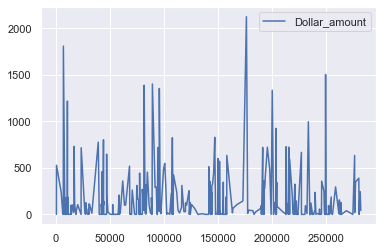

In [9]:
df[df['Outcome']==1][['Dollar_amount']].plot() #Fraudulent transactions dollar amounts during 48h

In [10]:
df[df['Outcome']==1].groupby('Dollar_amount')['Dollar_amount'].count().sort_values(ascending=False).head(5)
#Most popular amounts - 1 Dollar being most common

Dollar_amount
1.00     105
99.99     27
0.00      25
0.76      17
0.77      10
Name: Dollar_amount, dtype: int64

In [11]:
df[df['Outcome']==1].groupby('hour')['hour'].count().sort_values(ascending=False).head(5) 
#Time of a day of fraudent transactions (mostly 2AM, 11-12AM)

hour
2.0     44
12.0    33
11.0    32
18.0    28
16.0    28
Name: hour, dtype: int64

Text(0, 0.5, 'Amount (Dollars)')

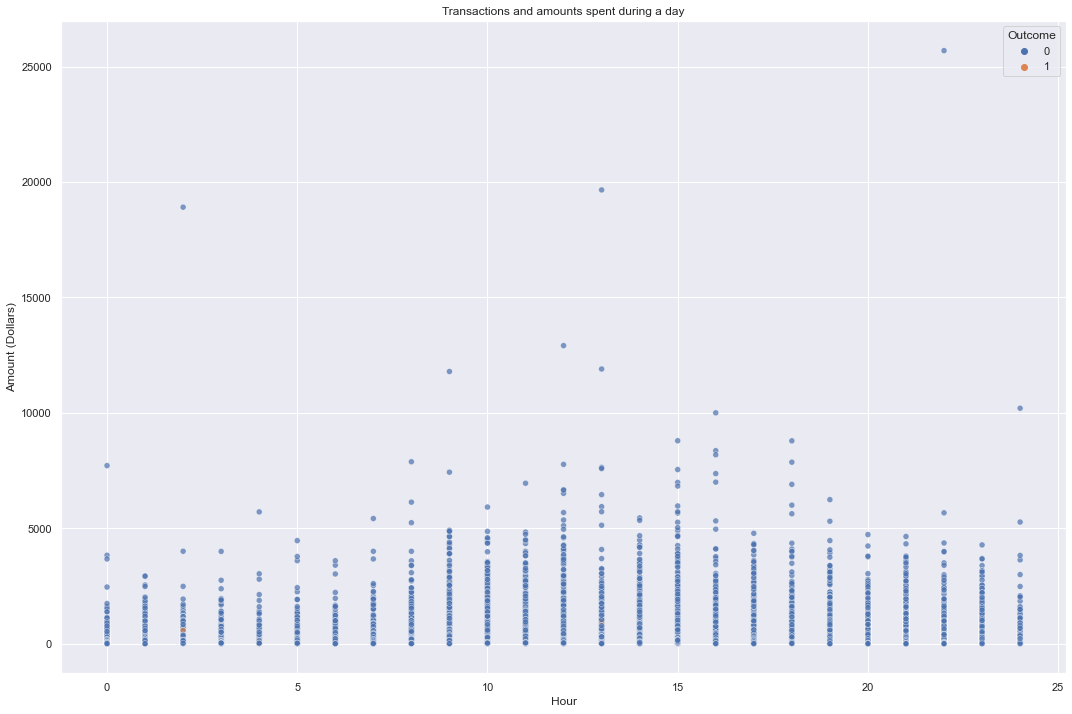

In [12]:
plt.figure(figsize=(18,12))   #visualisation of dollar amount vs hour of a day
sns.scatterplot(
    x=df['hour'], y=df['Dollar_amount'],
    hue=df['Outcome'],
    legend="full",
    alpha=0.7
)

plt.title("Transactions and amounts spent during a day")
plt.xlabel("Hour")
plt.ylabel("Amount (Dollars)")

<AxesSubplot:>

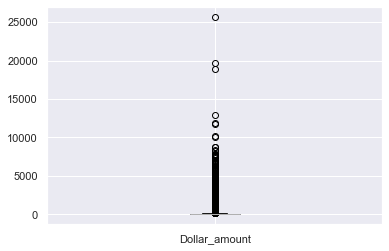

In [13]:
df[['Dollar_amount']].boxplot()  #most of the amounts are under 10.000 dollars

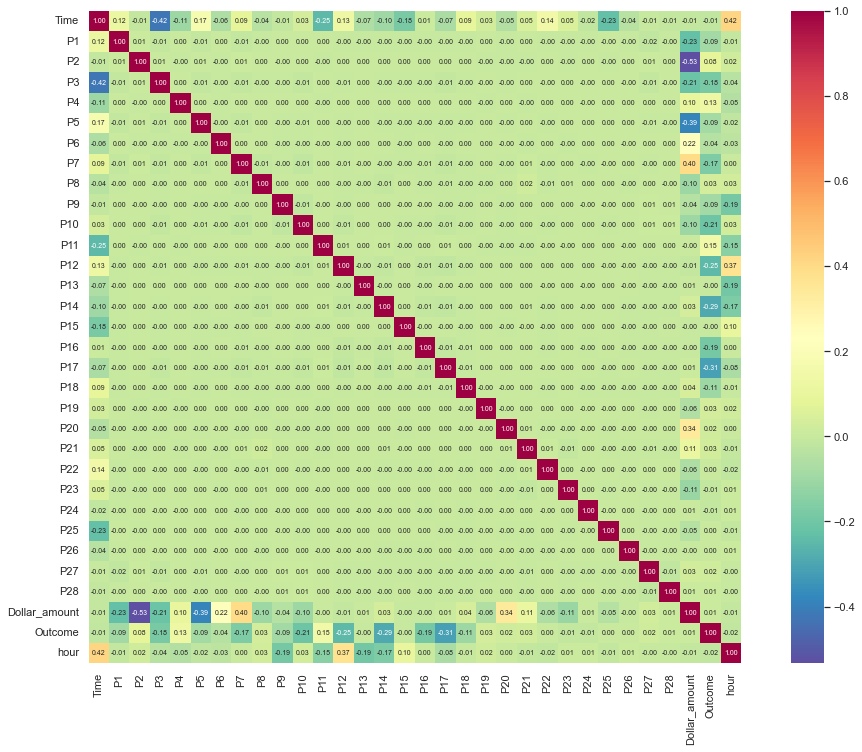

In [14]:
corr_matrix = df.corr()  #analysing correlations between features
plt.figure(figsize=(18,12))

hm = sns.heatmap(corr_matrix, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 7}, 
                 yticklabels=df.columns, 
                 xticklabels=df.columns, 
                 cmap="Spectral_r")
plt.show()

Text(0, 0.5, 'PCA Component 2')

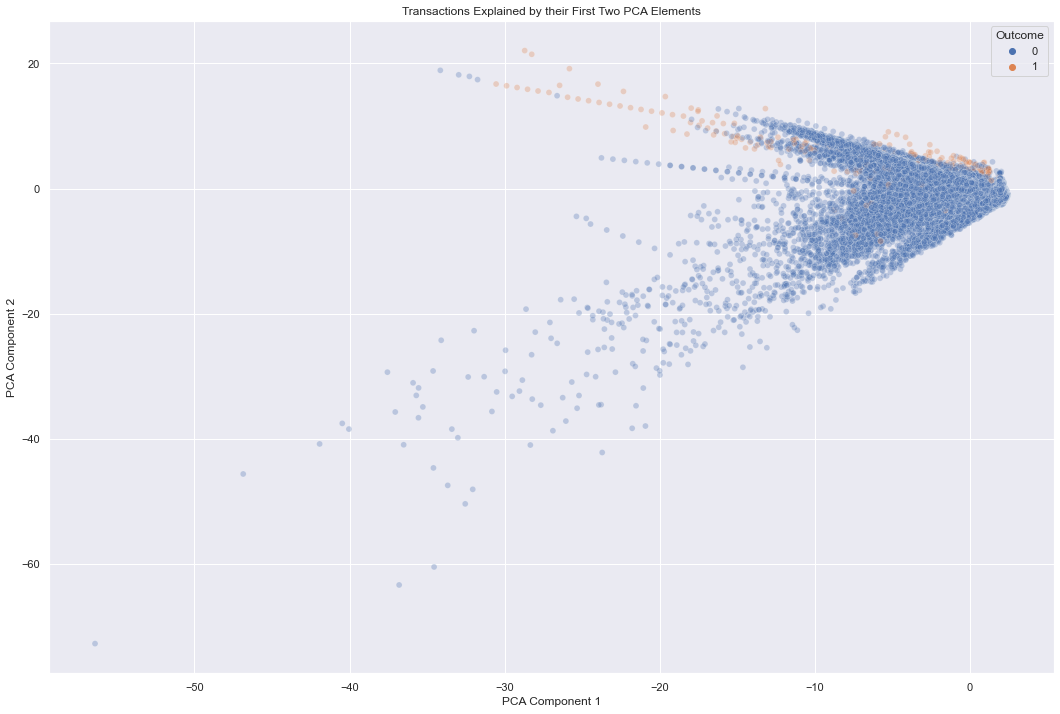

In [15]:
plt.figure(figsize=(18,12))   #analysing first two PCA elements
sns.scatterplot(
    x=df['P1'], y=df['P2'],
    hue=df['Outcome'],
    legend="full",
    alpha=0.3
)

plt.title("Transactions Explained by their First Two PCA Elements")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

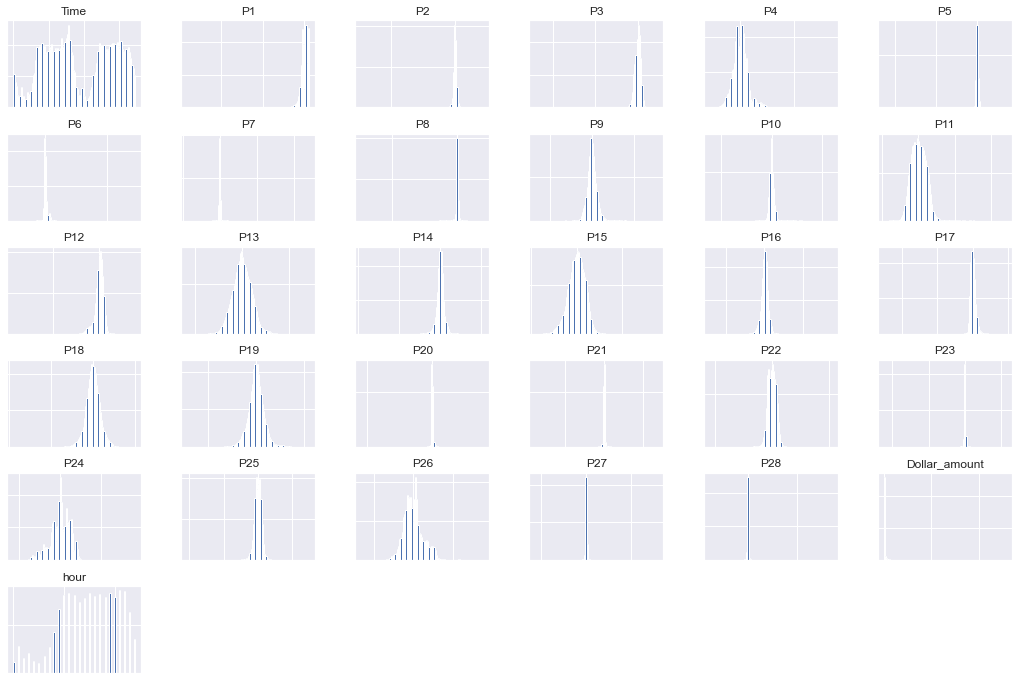

In [16]:
ax = df.drop("Outcome", axis=1).hist(figsize=(18,12),bins=100)
# plotting the histograms for all input attributes
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

In [17]:
df.sample(10)

,Time,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P22,P23,P24,P25,P26,P27,P28,Dollar_amount,Outcome,hour
126487,78017.0,1.272287,0.319855,-0.063514,0.441530,0.269658,-0.110140,0.025806,-0.040381,0.009267,...,-0.828628,0.048770,-0.793196,0.272502,0.174470,-0.004401,0.020021,1.98,0,22.0
53976,46240.0,1.165798,-0.317388,1.295899,0.182243,-1.162435,-0.180699,-0.744596,0.138758,1.007516,...,0.064854,0.132054,0.486502,0.011561,0.999437,-0.013104,0.015742,1.00,0,13.0
263714,161079.0,-0.938468,0.317067,0.757882,-2.098028,-0.768647,-0.740289,-0.064107,-0.254067,-2.623086,...,0.745557,-0.584362,-0.029874,0.675850,0.309390,-0.751102,-0.259267,18.00,0,21.0
168709,119347.0,-3.598131,-0.449874,-0.505042,-0.774306,1.667005,-0.335157,1.304230,-1.047608,0.690643,...,0.994118,-0.615293,0.321118,0.482778,-0.277178,-1.953266,1.240658,89.25,0,9.0
202436,134328.0,1.527467,-1.468849,-0.905209,0.642346,-0.578826,0.693783,-0.430958,0.109997,-0.461443,...,-1.610351,0.238376,0.112842,-0.528167,-1.117474,0.020843,0.016744,278.92,0,13.0
282164,170703.0,2.267843,-1.486478,-0.506105,-1.574875,-1.521641,-0.405659,-1.459683,-0.017626,-0.865158,...,-0.811600,0.501683,0.640862,-0.611644,-0.514866,0.027440,-0.028968,18.44,0,23.0
37607,39034.0,1.196667,-0.566252,0.003583,-1.001764,0.076527,1.045831,-0.591301,0.423564,-1.325720,...,-0.132824,0.244230,-1.054656,-0.004052,-0.417878,0.049940,-0.010767,14.00,0,11.0
246125,153043.0,1.997101,-0.410678,-0.613593,0.142325,-0.122909,0.505418,-0.725618,0.176282,1.123829,...,0.823202,0.058928,0.136030,0.004756,-0.229436,0.038141,-0.045036,4.99,0,19.0
223110,143251.0,1.910873,0.105630,-2.351803,0.719072,1.806827,1.099552,0.474491,0.142914,-0.443684,...,0.750995,-0.018038,-0.934790,0.343160,-0.406784,0.005694,-0.079064,29.74,0,16.0
34367,37635.0,1.357710,-0.779272,0.961301,-0.607049,-1.644669,-0.767357,-1.104622,0.008257,-0.195163,...,0.944013,-0.093480,0.392344,0.378304,-0.045519,0.027305,0.024345,19.99,0,10.0


## Preparing datasets for training

In [18]:
df = df.drop('Time', axis=1) #dropping Time column (using hour instead)

In [19]:
train, test = train_test_split(df, test_size=0.3, random_state=12, stratify=df[["Outcome"]]) 
#splitting dataset and making sure the same percantage of fraud is in each set

train_value_counts = train["Outcome"].value_counts()
print("Fraudulent transactions are %.2f%% of the training set." % (train_value_counts[1] * 100 / len(train)))
test_value_counts = test["Outcome"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (test_value_counts[1] * 100 / len(test)))

Fraudulent transactions are 0.17% of the training set.
Fraudulent transactions are 0.17% of the test set.


In [20]:
X_train = train.iloc[:, train.columns != "Outcome"]  #splitting datasets for thr training and test
y_train = train.iloc[:, train.columns == "Outcome"]
X_test = test.iloc[:, test.columns != "Outcome"]
y_test = test.iloc[:, test.columns == "Outcome"]
X_train.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P21,P22,P23,P24,P25,P26,P27,P28,Dollar_amount,hour
203573,-0.639554,0.856812,-0.200359,-0.517786,0.481725,-0.320542,0.483213,0.430447,0.237550,-0.711917,...,0.096827,0.387072,-0.306718,-0.977396,-0.034256,0.472937,0.236138,0.139158,16.92,13.0
70349,1.317368,0.356521,-0.038404,0.492634,0.064986,-0.585943,0.087917,-0.166800,0.044914,-0.289797,...,-0.339915,-0.959601,0.022771,-0.487557,0.338579,0.145573,-0.022051,0.022794,0.89,15.0
105477,0.813200,1.529745,-2.379692,1.201292,1.839932,-0.308863,0.733631,0.103239,-0.478511,-1.056059,...,-0.159856,-0.211603,-0.064486,-1.695835,-0.390737,-0.303682,0.266356,-0.013065,2.28,19.0
162518,-0.317734,0.737788,1.470501,3.110914,0.766844,0.693007,-0.049825,0.280865,-1.230355,1.167472,...,0.348099,1.026596,0.058454,-0.335912,-0.816096,-0.039012,0.012537,0.168206,0.00,8.0
31785,1.149523,-0.711810,-0.198244,0.029826,1.279629,4.416378,-1.310352,1.190590,1.418352,-0.423416,...,-0.354967,-0.768897,-0.031456,1.057159,0.517714,0.313963,0.032215,0.021158,34.33,10.0


## Grid Search with k-fold crossvalidation

Grid search is a process that searches exhaustively through a manually specified subset of the hyperparameter space of the targeted algorithm.
In this situation we are searching the best paratemers among:
- Gamma
- Max Depth
- Min Child Weight
- Subsample
- Colsample by Tree
- Learning Rate

With K-fold Cross-Validation the dataset is split into a 3 number of folds and is used to evaluate the model's ability when given new data. 

In [21]:
#The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean.

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [22]:
def xgboost_search(X, y, search_verbose=1):    #grid search with k-fold crossvalidation
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5], #the larger, the more conservative the algorithm will be
    "max_depth":[3,4,5,6], #Increasing this value will make the model more complex and more likely to overfit
    "min_child_weight": [100],  #the larger, the more conservative the algorithm will be
    "subsample": [0.6, 0.8, 1.0], #prevents overfitting
    "colsample_bytree": [0.6, 0.8, 1.0], #subsample ratio of columns when constructing each tree
    "learning_rate": [0.1, 0.01, 0.001], #Step size shrinkage used in update to prevents overfitting
    "scale_pos_weight":[5]   #increasing weight of fraud
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric=f1_eval, use_label_encoder=False, verbosity = 0)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=12) #3 folds in K-fold cross-validation
    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring='f1_micro', n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)
    grid_search.fit(X, y) #running grid search
    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)
    return grid_search.best_params_

In [23]:
warnings.filterwarnings('ignore')

In [24]:
rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 5000)  
#searching best parameters on 5000 transactions (due to huge size of dataset)
model_params = xgboost_search(X_train.iloc[rows,], y_train.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False,
              eval_metric=<function f1_eval at 0x7fd3758d61f0>, gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=0.6, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 100, 'scale_pos_weight': 5, 'subsample': 0.6}
Highest AUC: 1.00


## Xgboost model training

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [25]:
model = XGBClassifier(objective="binary:logistic", eval_metric=f1_eval, use_label_encoder=False)
model.set_params(**model_params) #using best parameters from grid search to train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False,
              eval_metric=<function f1_eval at 0x7fd3758d61f0>, gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=0.6, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Model evaluation

Since data are very unbalanced (as usually fraud is), the best metrics wouldn't be accuracy but Recall (we want to protect customers) and F1 Score (we protect customers but with balanced for precision - so we don't block too many transations) 

In [26]:
y_pred=model.predict(X_test)

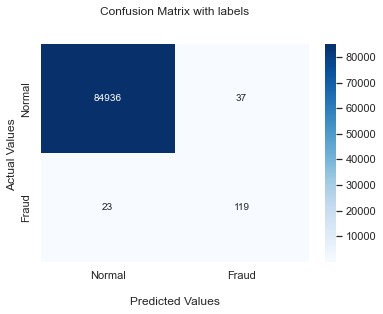

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix with labels\n\n'); #visualising confusion matrix
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Normal','Fraud'])
ax.yaxis.set_ticklabels(['Normal','Fraud'])
plt.rcParams['figure.figsize'] = [5, 3]

plt.show()

In [28]:
print('Recall: %.3f' % recall_score(y_test, y_pred))  #Recall and F1 Score for the trained model
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Recall: 0.838
F1 Score: 0.799


## Feature importance & selection

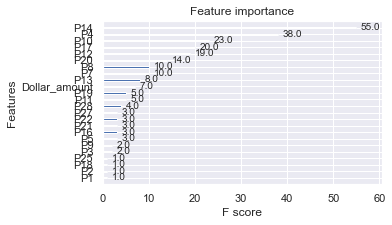

In [29]:
plot_importance(model)   #Features: P14, P4, P10, P17 have the higgest F Score - how many times was this variable split on
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()

In [30]:
thresholds = sort(model.feature_importances_)  #fitting model on different thresholds of features based on the feature importance
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier(objective="binary:logistic", eval_metric=f1_eval, colsample_bytree = 0.6, gamma = 0.5, 
                                    learning_rate =  0.1, max_depth = 3, min_child_weight=  100,  scale_pos_weight= 5,  subsample= 0.6, 
                                    use_label_encoder=False) 
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    f_score = f1_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, F1 score: %.2f" % (thresh, select_X_train.shape[1], f_score))

Thresh=0.000, n=30, F1 score: 0.80
Thresh=0.000, n=30, F1 score: 0.80
Thresh=0.000, n=30, F1 score: 0.80
Thresh=0.000, n=30, F1 score: 0.80
Thresh=0.000, n=30, F1 score: 0.80
Thresh=0.000, n=30, F1 score: 0.80
Thresh=0.000, n=24, F1 score: 0.79
Thresh=0.002, n=23, F1 score: 0.79
Thresh=0.005, n=22, F1 score: 0.79
Thresh=0.008, n=21, F1 score: 0.78
Thresh=0.008, n=20, F1 score: 0.77
Thresh=0.010, n=19, F1 score: 0.79
Thresh=0.010, n=18, F1 score: 0.78
Thresh=0.011, n=17, F1 score: 0.79
Thresh=0.012, n=16, F1 score: 0.79
Thresh=0.012, n=15, F1 score: 0.79
Thresh=0.014, n=14, F1 score: 0.79
Thresh=0.016, n=13, F1 score: 0.80
Thresh=0.016, n=12, F1 score: 0.81
Thresh=0.018, n=11, F1 score: 0.80
Thresh=0.020, n=10, F1 score: 0.78
Thresh=0.021, n=9, F1 score: 0.78
Thresh=0.023, n=8, F1 score: 0.77
Thresh=0.029, n=7, F1 score: 0.77
Thresh=0.039, n=6, F1 score: 0.78
Thresh=0.069, n=5, F1 score: 0.78
Thresh=0.115, n=4, F1 score: 0.78
Thresh=0.135, n=3, F1 score: 0.78
Thresh=0.152, n=2, F1 score

### Thresh=0.016 with 12 features has the highest F1 score -  0.81%

In [31]:
selection = SelectFromModel(model, threshold=0.016, prefit=True)

In [32]:
feature_idx = selection.get_support()  #retrieving the original names of columns from the best model 
feature_name = X_test.columns[feature_idx]

In [33]:
feature_name #features which obtained highest F1 Score

Index(['P1', 'P3', 'P4', 'P7', 'P10', 'P11', 'P12', 'P14', 'P16', 'P17', 'P18',
       'P21'],
      dtype='object')

## Possible improvements:
- oversampling methods (SMOTE) since the data are very inbalanced
- using SHAP values instead of pre-built feature importance
- grid search on bigger amount of data and different hyper-parameters
- analyzing data and detecting fraud with unsupervised learning (clustering)